In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import fipy as fp
from fipy.tools.dump import read
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as p
from fvm_utils import *
import torch

print(torch.cuda.is_available())

True


# Hybrid parameter estimation: linear regression and neural networks

Inspired by some scribbles on a Zoom whiteboard with Danny Seara, see below

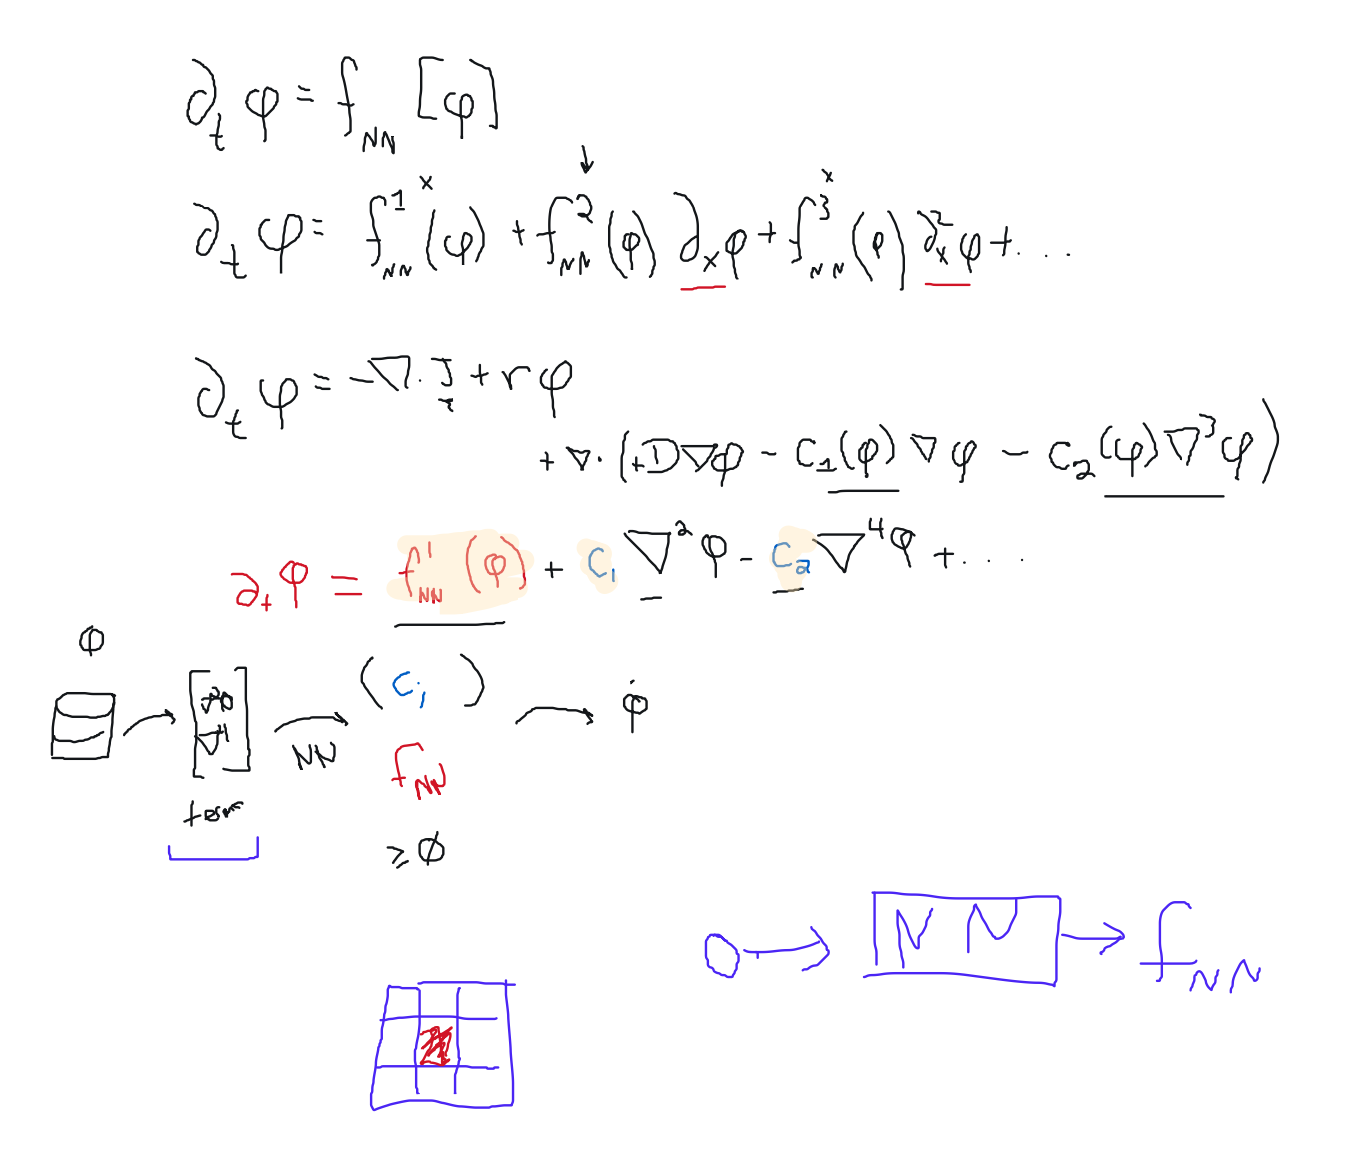

Pre-loading all Fipy data from files
Done (t = 2.3 s)
W0_mesh (607,)
B0_mesh (607,)
W1_mesh (607,)
B1_mesh (607,)
t0 ()
t1 ()
features_mesh List of length 2
X torch.Size([607])
Y torch.Size([607])
W0 (607,)
B0 (607,)
W1 (607,)
B1 (607,)
features torch.Size([2, 7, 607])
dt_W (607,)
dt_B (607,)
inputs torch.Size([2, 607])
targets torch.Size([2, 607])


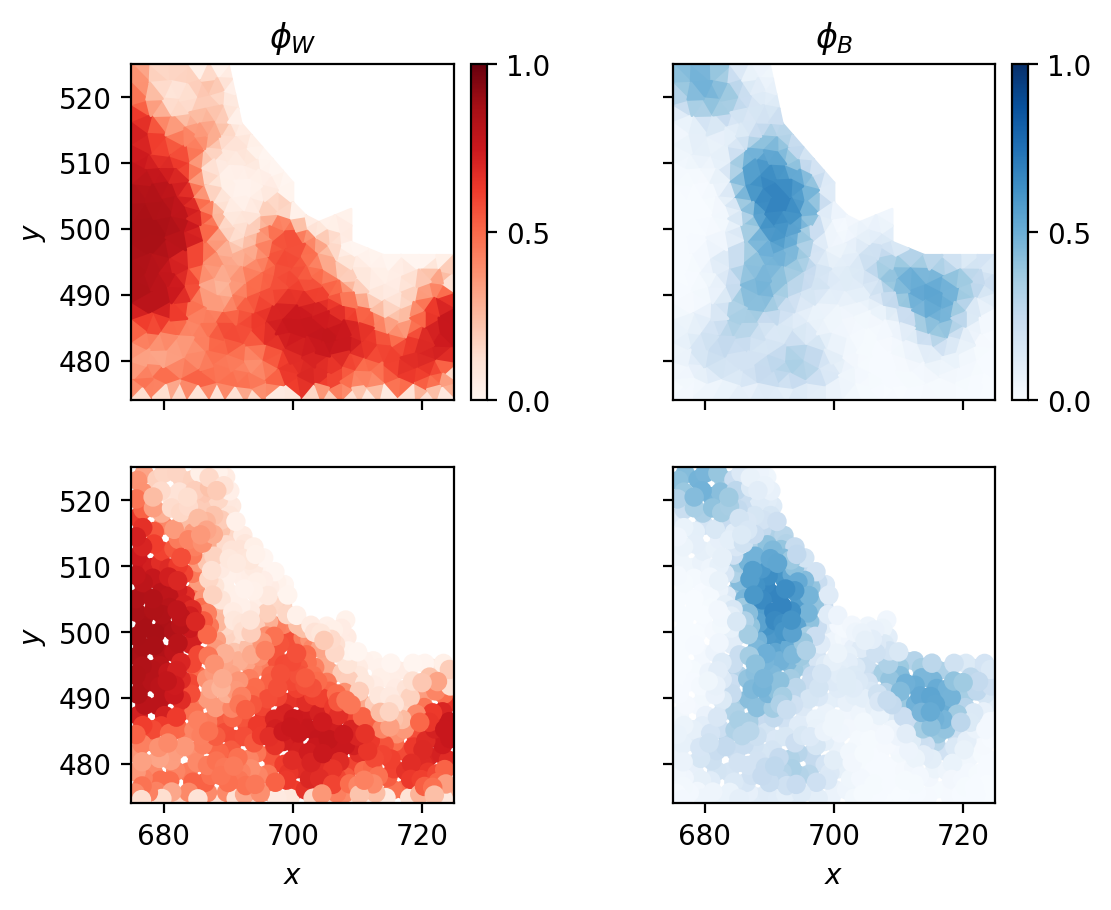

In [2]:
from fipy_dataset import FipyDataset

dataset = FipyDataset(path="./data/Illinois_Cook_small/fipy_output",
                      grid=False,
                      remove_extra=False,
                      preload=True)
sample = dataset[5]

for key in sample:
    try:
        print(key, sample[key].shape)
    except:
        if isinstance(sample[key], list):
            print(key, 'List of length', len(sample[key]))
        else:
            print(key, sample[key])

# Plot everything to make sure that things look correct
from fvm_utils import plot_mesh
fig, ax = plt.subplots(2, 2, dpi=200, sharex=True, sharey=True)

# Plot original fipy objects
plot_mesh(sample['W0_mesh'], sample['W0_mesh'].mesh, ax[0, 0], cmap=plt.cm.Reds, vmin=0, vmax=1)
plot_mesh(sample['B0_mesh'], sample['B0_mesh'].mesh, ax[0, 1], cmap=plt.cm.Blues, vmin=0, vmax=1)

# Plot 
try:
    ax[1, 0].pcolormesh(sample['X'], sample['Y'], sample['inputs'][0], cmap='Reds', vmin=0, vmax=1)
    ax[1, 1].pcolormesh(sample['X'], sample['Y'], sample['inputs'][1], cmap='Blues', vmin=0, vmax=1)
except:
    ax[1, 0].scatter(sample['X'], sample['Y'], c=sample['inputs'][0], cmap='Reds', vmin=0, vmax=1)
    ax[1, 1].scatter(sample['X'], sample['Y'], c=sample['inputs'][1], cmap='Blues', vmin=0, vmax=1)

ax[0, 0].set_title('$\\phi_W$')
ax[0, 1].set_title('$\\phi_B$')

ax[0, 0].set_ylabel('$y$')
ax[1, 0].set(xlabel='$x$', ylabel='$y$')
ax[1, 1].set_xlabel('$x$')

for a in ax.flatten():
    a.set_aspect(np.ptp(a.get_ylim()) / np.ptp(a.get_xlim()))

In [6]:
sample["W0_mesh"].mesh._cellVolumes

array([3.55450043, 3.66551801, 4.79634461, 3.35663453, 2.9508404 ,
       3.56904573, 4.08765527, 4.28275064, 4.81600023, 3.67056925,
       2.2218573 , 3.11168012, 3.4892204 , 3.62432132, 3.55015948,
       4.84331004, 3.2378175 , 3.28716547, 2.93411255, 4.60675482,
       2.2771982 , 3.58066878, 3.10582194, 3.15208045, 3.94902551,
       3.04792349, 4.94584511, 3.42327456, 4.31548197, 3.58014399,
       3.44673987, 3.98338398, 3.06630097, 4.41544699, 3.81422353,
       4.13093216, 2.80321391, 3.64774185, 3.27868193, 2.76466543,
       4.32858498, 3.65602912, 4.31554038, 4.31554038, 4.56974535,
       5.42950232, 4.72533786, 3.88094778, 3.15505471, 3.87053808,
       3.20395369, 2.62541344, 5.45561031, 4.60215972, 4.8156813 ,
       2.59685499, 2.66786663, 3.05670542, 3.86003774, 2.73393103,
       4.59969399, 3.79767515, 3.10519817, 5.55343021, 4.27227324,
       3.88709981, 2.6333233 , 3.31427136, 3.27107774, 3.12454554,
       4.59157229, 3.84116358, 2.79468913, 4.01304449, 4.24888

In [4]:
from fipy_nn import SociohydroParameterNetwork, ParameterNetwork
model = SociohydroParameterNetwork()
model.print()

outputs, _ = model(sample['inputs'], sample['features'], batched=False)
print(outputs.shape)                                 

dt ϕW = 1 T_W + 0 k_WW + 0 k_WB + 0 ν_WWW + 0 ν_WWB + 0 ν_WBB + -1 Γ_W + NN(['ϕW', 'ϕB'])
dt ϕB = 1 T_B + 0 k_BB + 0 k_BW + 0 ν_BBB + 0 ν_BWB + 0 ν_BWW + -1 Γ_B + NN(['ϕW', 'ϕB'])
torch.Size([2, 607])


In [3]:
from train_fipy_nn import JointLossFunction

loss = JointLossFunction(beta=1.)

loss(sample['targets'][None],
     sample['targets'][None],
     sample['inputs'][None],
     sample['inputs'][None],
     sample['inputs'][None])

tensor(0.6376)

0.09999999999999998